In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import scipy.optimize as sco

In [2]:
HSI = pd.read_csv('^HSI.csv')[:483]
COR = pd.read_csv('Corporate.csv')[:483]
SPY = pd.read_csv('SPY.csv')[:483]
Rea = pd.read_csv('DJ.csv')[:483]
Gol = pd.read_csv('GOL.csv')[:483]
TYX = pd.read_excel('^TYX.xls')[:483]
BTC = pd.read_csv('BTC.csv')[:483]

In [3]:
def cum_ret(df):
    df['log_ret'] = np.log(df['Price']/df['Price'].shift(1))
    df['cum_ret'] = df['log_ret'].cumsum()
    df['st_pri'] = df['Price']/df['Price'][0]
    
    return df[['Date', 'Price', 'log_ret', 'cum_ret', 'st_pri']]

In [4]:
HSI_ret = cum_ret(HSI)
COR_ret = cum_ret(COR)
SPY_ret = cum_ret(SPY)
Rea_ret = cum_ret(Rea)
Gol_ret = cum_ret(Gol)
TYX_ret = cum_ret(TYX)
BTC_ret = cum_ret(BTC)

In [5]:
portfolio = pd.DataFrame()
portfolio[['Date', 'HSI']] = HSI_ret[['Date', 'cum_ret']]
portfolio['COR'] = COR_ret['cum_ret']
portfolio['SPY'] = SPY_ret['cum_ret']
portfolio['Rea'] = Rea_ret['cum_ret']
portfolio['Gol'] = Gol_ret['cum_ret']
portfolio['TYX'] = TYX_ret['cum_ret']
portfolio['BTC'] = BTC_ret['cum_ret']
portfolio = portfolio.dropna()
portfolio

,Date,HSI,COR,SPY,Rea,Gol,TYX,BTC
1,7/26/10,0.010251,0.001769,0.033892,0.071073,0.001051,-0.005204,0.000000
2,8/2/10,0.040645,0.006551,0.056869,0.094325,-0.017174,-0.011309,0.000000
3,8/9/10,0.012235,0.013027,0.055134,0.086818,0.015436,-0.001905,0.000000
4,8/16/10,0.007967,0.024624,0.056412,0.038726,0.020804,0.048934,0.000000
5,8/23/10,-0.010527,0.025321,0.069469,0.030825,0.028393,0.060686,0.000000
...,...,...,...,...,...,...,...,...
475,8/26/19,0.211763,0.381030,1.114937,0.812132,0.234672,0.647042,11.471520
478,9/16/19,0.239024,0.368616,1.058861,0.806149,0.234207,0.589143,11.512225
479,9/23/19,0.220667,0.380344,1.077417,0.818900,0.233408,0.622198,11.315511
480,9/30/19,0.215500,0.382355,1.103192,0.823787,0.225386,0.632201,11.305569


In [6]:
portfolio['Date']=portfolio['Date'].apply(lambda x:datetime.datetime.strptime(x, "%m/%d/%y") )
date = portfolio.Date.astype('O')

/Users/wentingshi/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


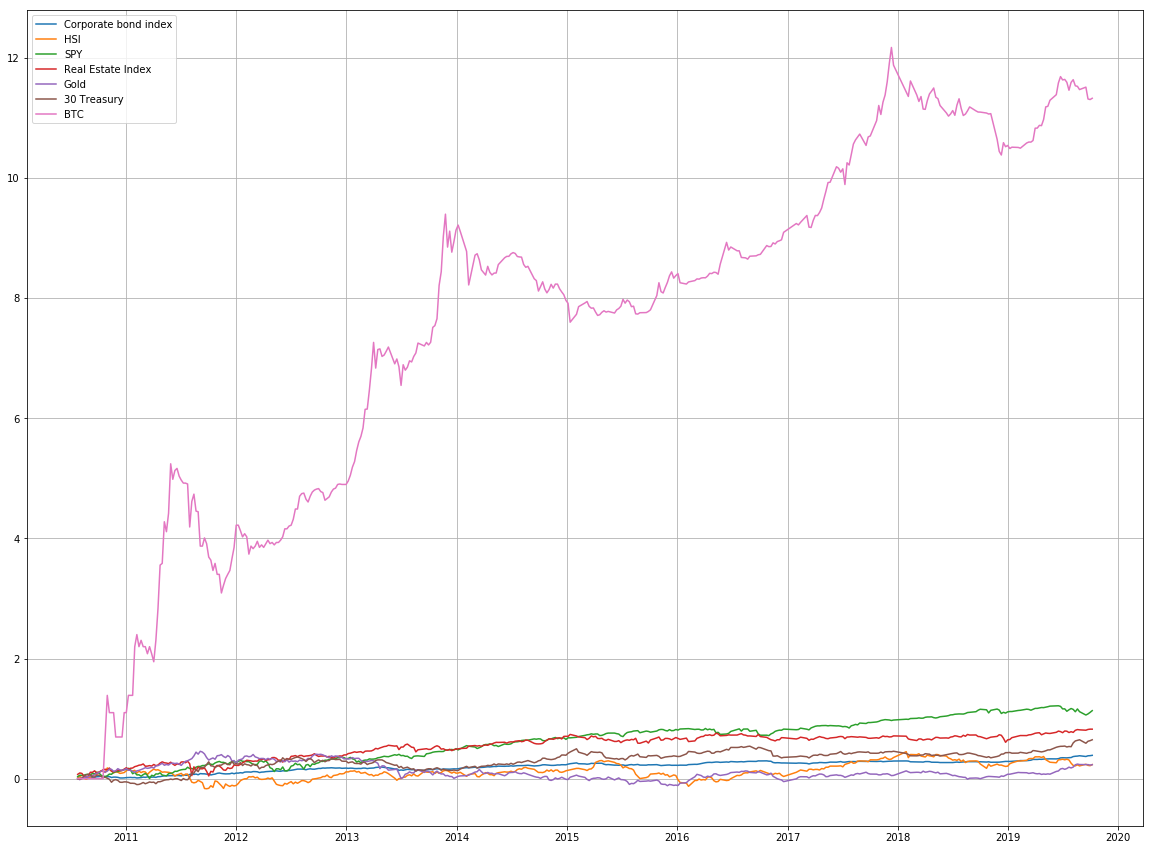

In [7]:
fig, ax = plt.subplots(figsize=(20,15))
plt.grid(True)
ax.plot(date, portfolio[['COR','HSI','SPY','Rea','Gol','TYX','BTC']])
ax.legend(['Corporate bond index','HSI','SPY','Real Estate Index','Gold','30 Treasury','BTC'])
ax.legend(loc='upper center', shadow=True, fontsize='xx-large')



In [8]:
portfolio.corr()

,HSI,COR,SPY,Rea,Gol,TYX,BTC
HSI,1.000000,0.588095,0.688583,0.586313,-0.424112,0.372768,0.651725
COR,0.588095,1.000000,0.938259,0.954314,-0.440711,0.931857,0.927655
SPY,0.688583,0.938259,1.000000,0.909782,-0.564812,0.830296,0.926719
Rea,0.586313,0.954314,0.909782,1.000000,-0.594427,0.835070,0.930072
Gol,-0.424112,-0.440711,-0.564812,-0.594427,1.000000,-0.273663,-0.492832
TYX,0.372768,0.931857,0.830296,0.835070,-0.273663,1.000000,0.778668
BTC,0.651725,0.927655,0.926719,0.930072,-0.492832,0.778668,1.000000


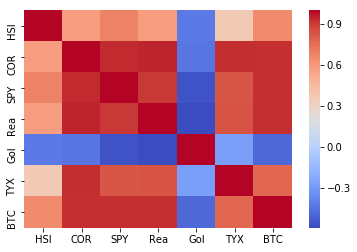

In [9]:
fig, ax = plt.subplots()
sns.heatmap(portfolio.corr(),cmap='coolwarm',ax=ax)

# Efficient Frontier

In [11]:
pf = pd.DataFrame()
pf['HSI'] = HSI_ret['log_ret']
pf['COR'] = COR_ret['log_ret']
pf['SPY'] = SPY_ret['log_ret']
pf['Rea'] = Rea_ret['log_ret']
pf['Gol'] = Gol_ret['log_ret']
pf['TYX'] = TYX_ret['log_ret']
pf['BTC'] = BTC_ret['log_ret']
pf = pf.dropna()

In [12]:
def cal_optimal_sharpe_pfl_weights(return_array):
    mu = np.average(return_array,0)
    S = np.cov(return_array.T)
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe(0)
    return raw_weights

In [13]:
weight_btc = cal_optimal_sharpe_pfl_weights(pf)
weight_btc

{0: 6.079233207428918e-17,
 1: 0.7748019059769742,
 2: 0.13591557998149834,
 3: 0.06735613346306331,
 4: 0.0,
 5: 5.558377432701714e-16,
 6: 0.02192638057846365}

In [14]:
pf_no_btc = pf.drop(['BTC'], axis=1)
weight_no_btc = cal_optimal_sharpe_pfl_weights(pf_no_btc)
weight_no_btc

{0: 0.0,
 1: 0.778411412185944,
 2: 0.14780629509498427,
 3: 0.07378229271907125,
 4: 0.0,
 5: 7.713591712148997e-16}

In [15]:
# plot efficient frontier


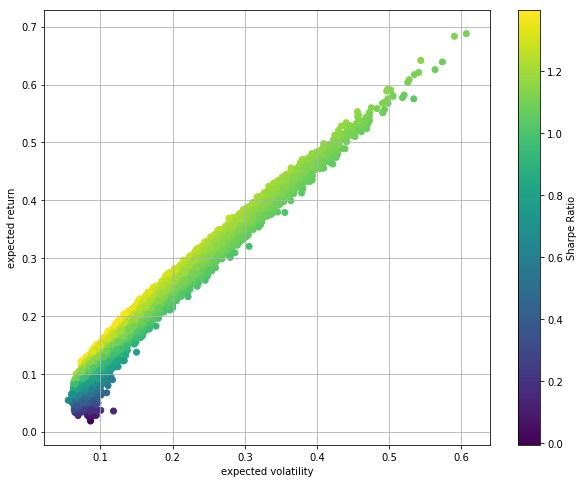

In [19]:
port_ret = []
port_vola = []
for x in range(8000):
    # create 7 random numbers which all between 0 and 1
    weights = np.random.random(7)
    # sum of weight=1
    weights /=np.sum(weights)
    # calculated the return and vola for each time
    port_ret.append(np.sum(pf.mean() * 52 * weights))
    port_vola.append(np.sqrt(np.dot(weights.T, np.dot(pf.cov() * 52, weights))))
    
port_ret = np.array(port_ret)
port_vola = np.array(port_vola)

risk_free = 0.0187
plt.figure(figsize = (10, 8))
plt.scatter(port_vola, port_ret, c = (port_ret - risk_free) / port_vola, marker = 'o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe Ratio')


In [40]:
risk_free_rate = 0.0187
noa = 7

def statistics(weights):
    weights = np.array(weights)
    port_returns = np.sum(pf.mean() * weights) * 52
    port_variance = np.sqrt(np.dot(weights.T, np.dot(pf.cov() * 52,weights)))
    port_sharpe_ratio = (port_returns - risk_free_rate) / port_variance
    return np.array([port_returns, port_variance, port_sharpe_ratio])

# max sharpe ratio
def min_sharpe(weights):
    return -statistics(weights)[2]

cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(noa))
opts = sco.minimize(min_sharpe, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)
opts['x']
# output: array([2.65769241e-16, 7.26083696e-01, 1.60810493e-01, 8.19177808e-02, 
#               4.85039006e-16, 6.73101810e-16, 3.11880308e-02])

# min volatility
def min_variance(weights):
    return statistics(weights)[1]

optv = sco.minimize(min_variance, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)
optv['x']
# output: array([0.03715611, 0.85176834, 0.07706092, 0.02547305, 0.0069559 ,
#               0.        , 0.00158568])

array([2.65769241e-16, 7.26083696e-01, 1.60810493e-01, 8.19177808e-02,
       4.85039006e-16, 6.73101810e-16, 3.11880308e-02])

In [84]:
# efficient frontier -- portfolio with min volatility on a given return
def efficient_frontier(df, target_returns):
    
    noa = df.shape[1]
    def statistics(weights):
        weights = np.array(weights)
        port_returns = np.sum(df.mean() * weights) * 52
        port_variance = np.sqrt(np.dot(weights.T, np.dot(df.cov() * 52,weights)))
        port_sharpe_ratio = (port_returns - risk_free_rate) / port_variance
        return np.array([port_returns, port_variance, port_sharpe_ratio])
    
    def min_variance(weights):
        return statistics(weights)[1]
    
    target_variance = []
    bnds = tuple((0,1) for x in range(noa))
    for tar in target_returns:
        cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},
                {'type':'eq','fun':lambda x:np.sum(x)-1})
        res = sco.minimize(min_variance, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)
        target_variance.append(res['fun'])
    
    return target_variance


In [92]:
target_returns = np.arange(.01, .12, .0001)
volatility_btc = efficient_frontier(pf, target_returns)
volatility_no_btc = efficient_frontier(pf_no_btc, target_returns)


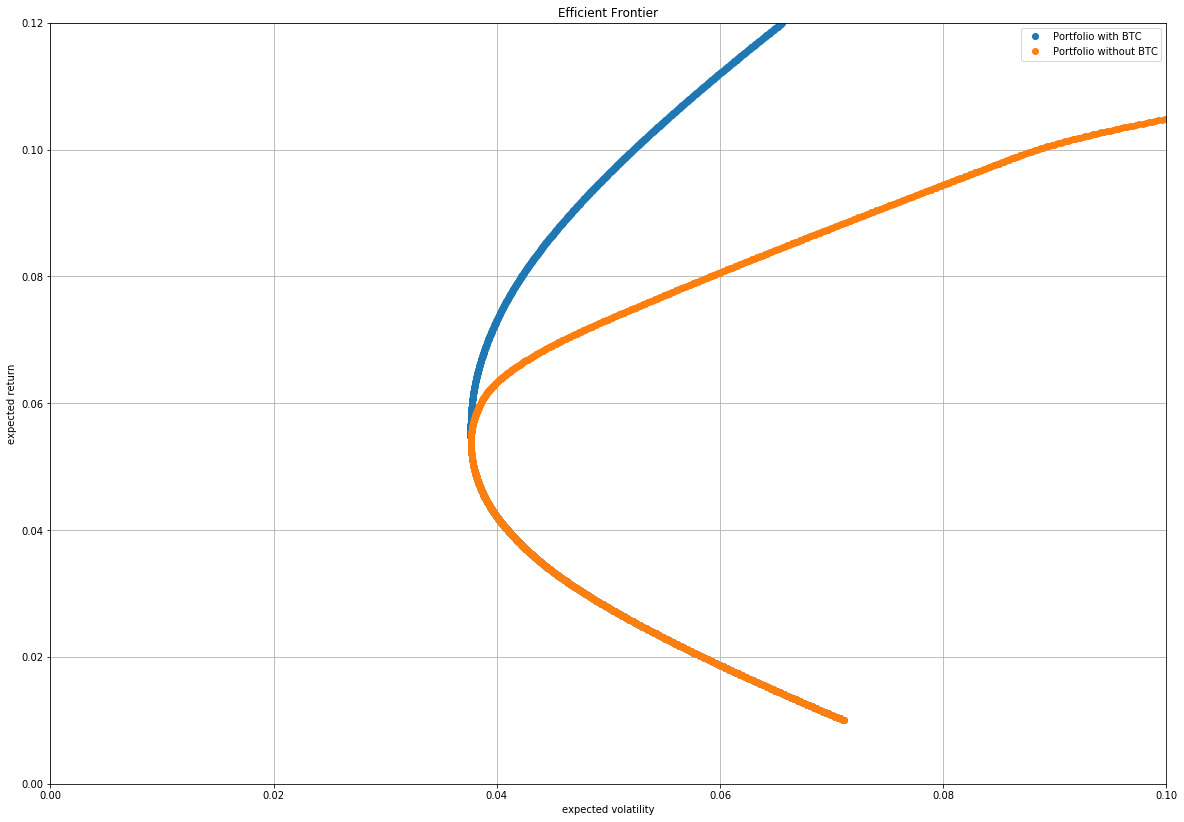

In [94]:
fig, axes = plt.subplots(figsize = (20, 14))
plt.plot(volatility_btc, target_returns, 'o')
plt.plot(volatility_no_btc, target_returns, 'o')
plt.grid(True)

plt.xlabel('expected volatility')
plt.ylabel('expected return')
axes.set_xlim([0, 0.10])
axes.set_ylim([0, 0.12])
axes.set_title('Efficient Frontier')
axes.legend(['Portfolio with BTC', 'Portfolio without BTC'])
